**Using Deep Reinforcement Learning to Fine Tune a Large Language Model for a Text Generation Task**

Task: A large language model (GPT) is pre-trained for producing positive continuation of input incomplete sentences (movie reviews). To improve the quality of generated text, use PPO (deep RL method) to fine tune the model. 


The language model (LM) GPT2 generates a continuation (response) based on an input query (incomplete review). We use a pretrained BERT classifier as 'Reward Model' to generate a scalar score / reward representing the quality of the response output from LM. In the optimisation step of PPO, we use a reference LM to make sure the responses generated from 'LM being fine tuned' do not deviate too far from the reference LM. PPO training process optimizes the weights of 'LM being fine tuned' by using process outlined in image below.

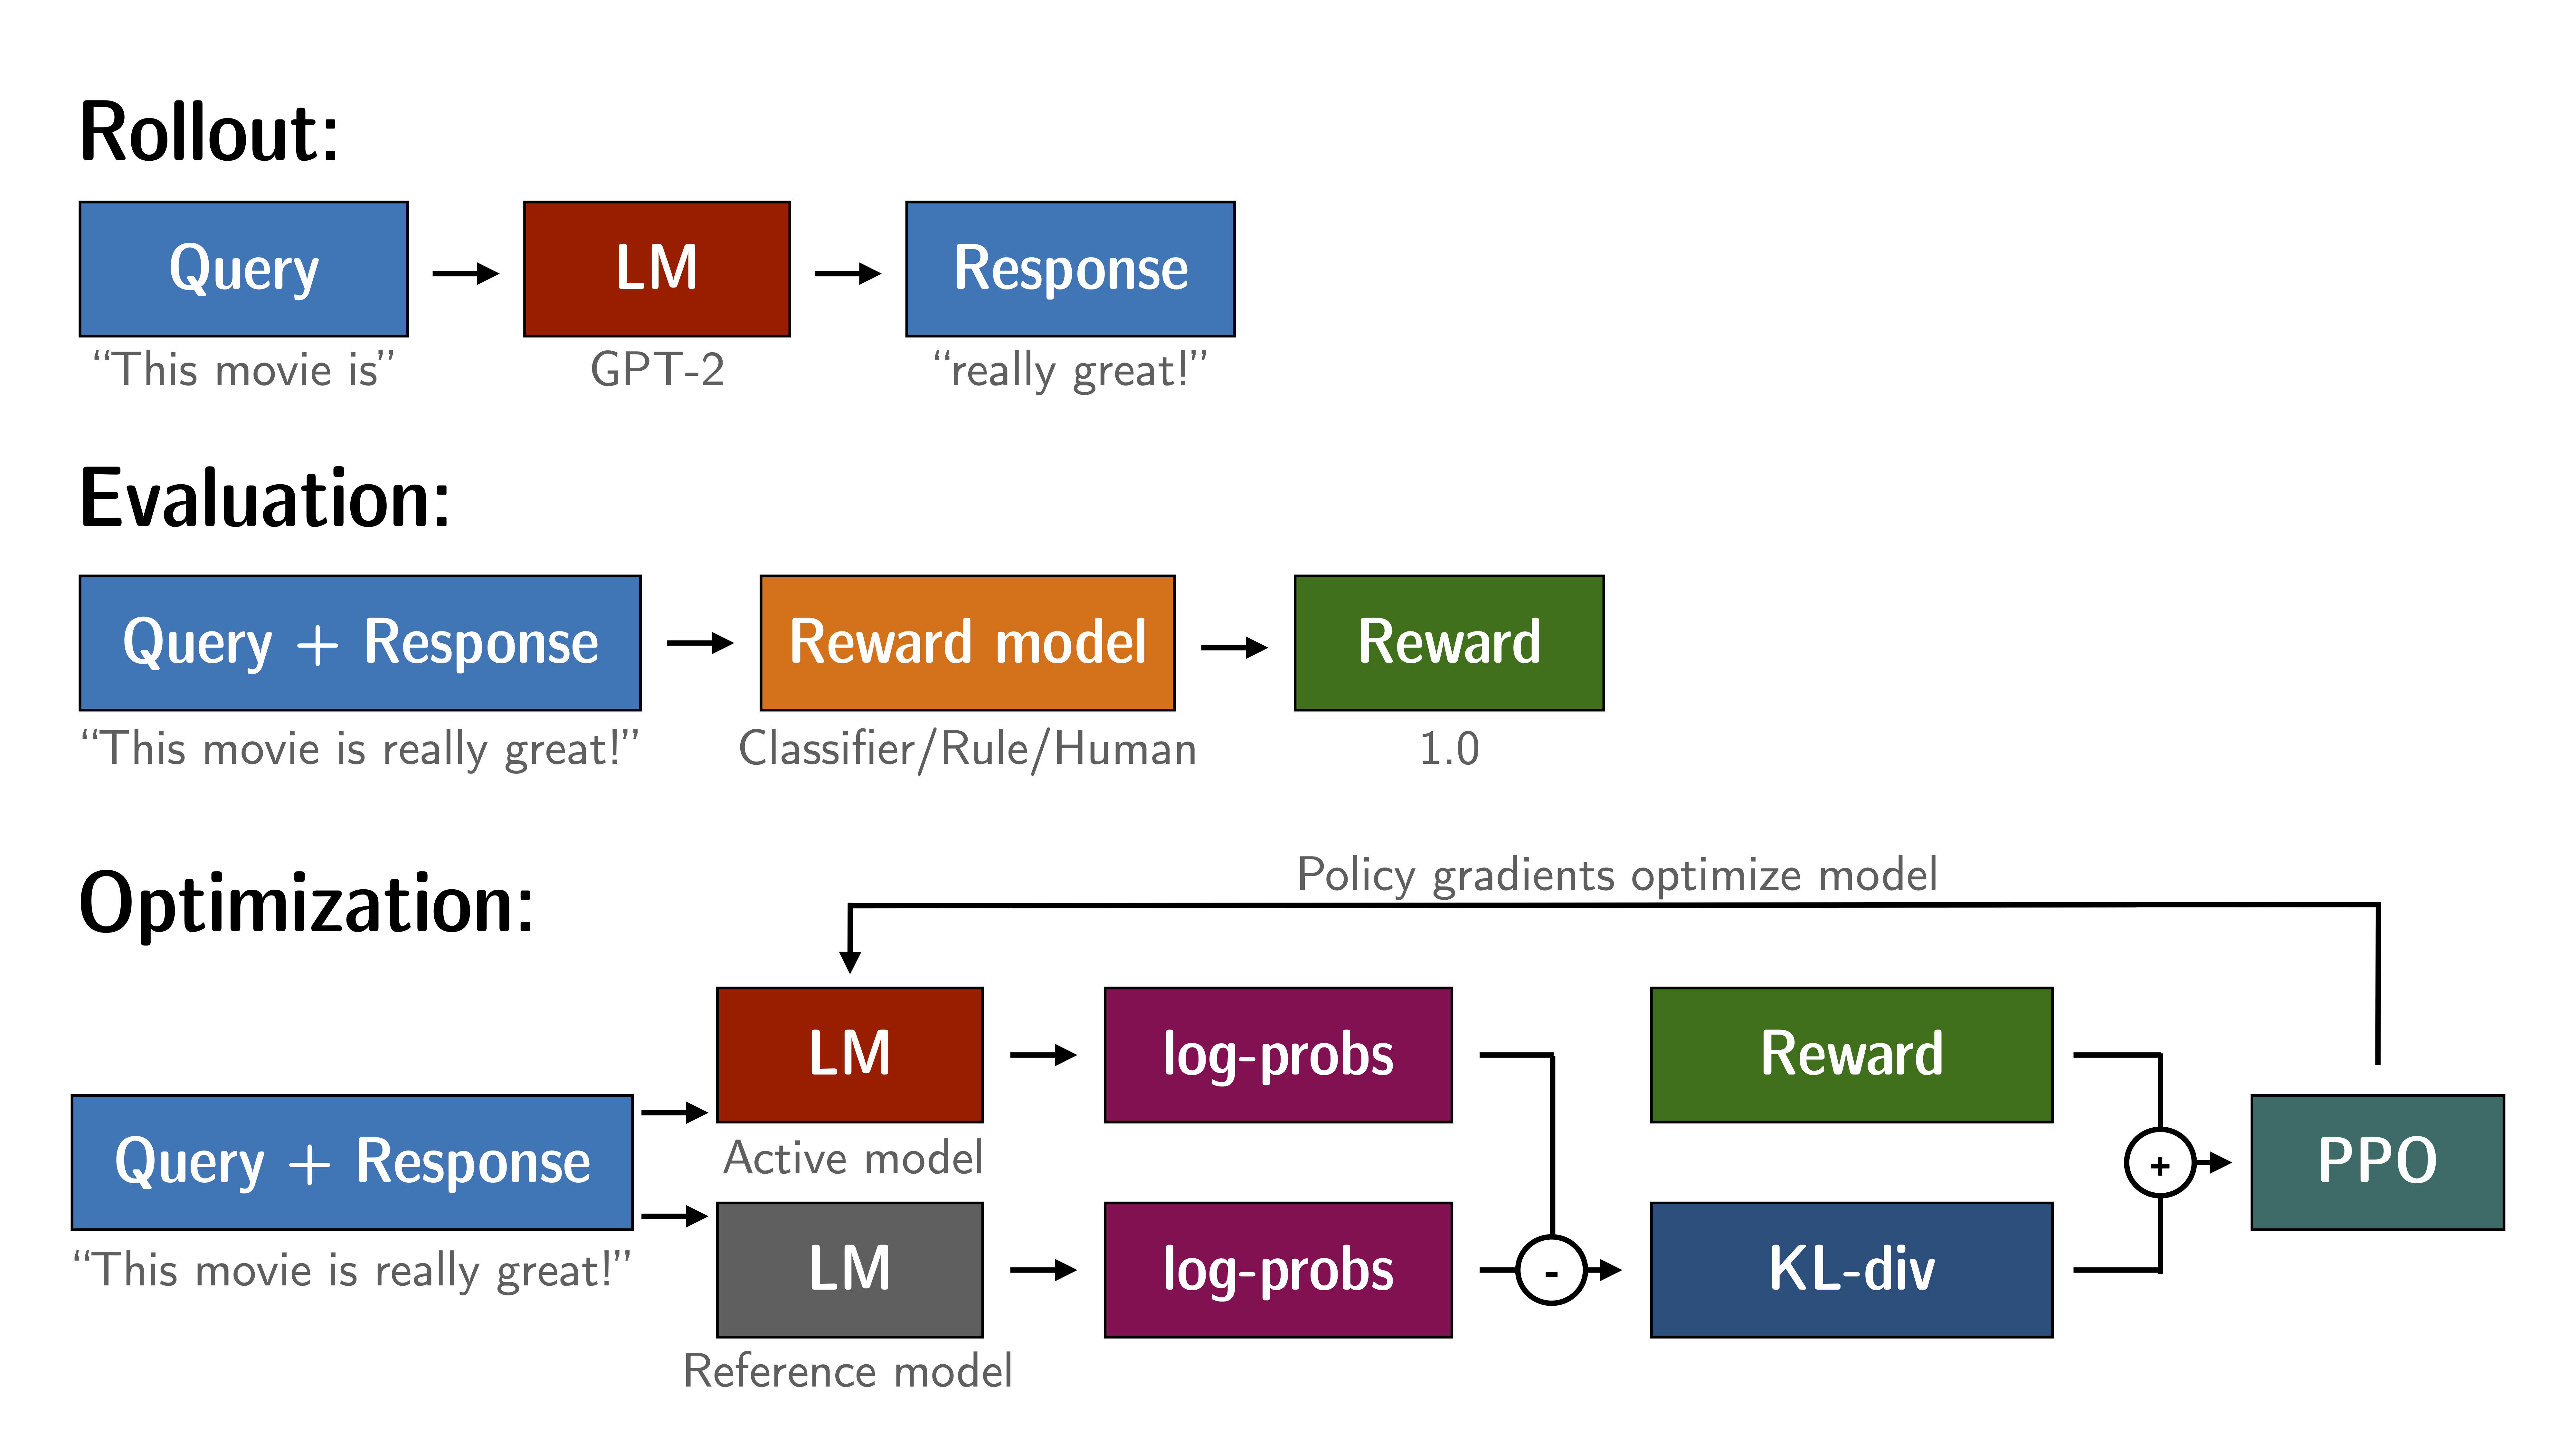

In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
! pip install -U accelerate
! pip install -U transformers
! pip install trl wandb

In [ ]:
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset


from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

In [5]:
# Create a configuration for PPO trainer class object 
config = PPOConfig(
    model_name="lvwerra/gpt2-imdb",
    learning_rate=1.4e-5,
)
# Using "batch_size": 8 because value 16 gave out of memory issues 
pipeline_sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": 8}

In [6]:
## Load dataset (he IMDB dataset contains 50k movie review annotated with "positive"/"negative" sentiment labels)

def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):
  tokenizer = AutoTokenizer.from_pretrained(config.model_name)
  tokenizer.pad_token = tokenizer.eos_token

  ds = load_dataset(dataset_name, split="train") # IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.
  ds = ds.rename_columns({"text": "review"})
  ds = ds.filter(lambda x: len(x["review"])>200, batched=False) # filter for comments that are at least 200 characters.
  inp_size = LengthSampler(input_min_text_length, input_max_text_length) # cut it to random size

  def tokenize(sample):
    sample["input_ids"] = tokenizer.encode(sample["review"])[:inp_size()] # tokenize each text
    sample["query"] = tokenizer.decode(sample["input_ids"])
    return sample

  ds = ds.map(tokenize, batched=False)
  ds.set_format(type="torch")
  return ds

In [7]:
dataset = build_dataset(config)

In [8]:
ds_check = load_dataset("imdb", split="train")
df_check = pd.DataFrame(ds_check)
df_check.head()


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [9]:
def data_collator(data):
  return dict((key, [d[key] for d in data]) for key in data[0])

In [10]:
model_gpt2 = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name) # model being fine tuned
model_gpt2 = model_gpt2.bfloat16()
ref_model_gpt2 = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name) # for computing KL divergence to make sure that fine tuned weights
# do not deviate too much from original weights

tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token


In [ ]:
ppo_trainer = PPOTrainer(config, model_gpt2, ref_model_gpt2, tokenizer, dataset=dataset, data_collator=data_collator)

In [12]:
# Load BERT Classifier fine tuned on IMDB data
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
  device = 0 if torch.cuda.is_available() else "cpu"

sentiment_pipe = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)

We will use the logits for positive class as a reward signal for the language model.

In [ ]:
sentiment_pipe("this movie was good", **pipeline_sent_kwargs)

In [14]:
sentiment_pipe("this movie was surprisingly bad", **pipeline_sent_kwargs)

[[{'label': 'NEGATIVE', 'score': 2.324246406555176},
  {'label': 'POSITIVE', 'score': -2.709864616394043}]]

In [15]:
sentiment_pipe("this movie was so so", **pipeline_sent_kwargs)

[[{'label': 'NEGATIVE', 'score': -1.104836344718933},
  {'label': 'POSITIVE', 'score': 1.2220337390899658}]]

The training loop consists of the following main steps:

*   Get the query responses from the policy network model_gpt2
*   Get sentiments for query/responses from BERT sentiment_pipe
*   Optimize policy model_gpt2 with PPO using the (query, response, reward) triplet while using KL divergence w.r.t. ref_model_gpt2


In [16]:
import numpy as np

In [20]:
# Training
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)
# For the response generation we just use sampling and make sure top-k and nucleus sampling are turned off as well as a minimal length.
gen_kwargs_training = {"min_length": -1, "top_k": 0.0, "top_p": 1.0, "do_sample": True, "pad_token_id": tokenizer.eos_token_id}

for epoch_id, batch in tqdm(enumerate(ppo_trainer.dataloader)):
  query_tensors = batch["input_ids"]

  ### Get sentiment response from GPT2
  response_tensors = []
  for query in query_tensors:
    gen_len = output_length_sampler()
    gen_kwargs_training["max_new_tokens"] = gen_len
    if query.isfinite().all().item():
      response = ppo_trainer.generate(query, **gen_kwargs_training)
      # the model gets the start of a real review and is tasked to produce positive continuations
      response_tensors.append(response.squeeze()[-gen_len:])
    else:
      print(f"query contents {query} can not be used for generate. Can't go \
            ahead because can't skip an element in queries")
      raise KeyboardInterrupt
  batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

  ### Compute sentiment score for (text, GPT2output) using BERT
  texts = [q+r for q,r in zip(batch["query"],batch["response"])]
  pipe_outputs = sentiment_pipe(texts, **pipeline_sent_kwargs)
  rewards = [torch.tensor(output[1]["score"]) for output in pipe_outputs]

  if sum([x.isnan().any().item() for x in query_tensors])==0 \
    and sum([x.isnan().any().item() for x in response_tensors])==0:
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)
  else:
    print(f"query_tensors has NaN {sum([x.isnan().any().item() for x in query_tensors])} or response_tensors \
          has NaN {sum([x.isnan().any().item() for x in response_tensors])}")


194it [43:31, 13.46s/it]


In [21]:
# Evaluate / Inspect how model performs

batch_sz = 8
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(batch_sz)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].to_list()
gen_kwargs_inspection = {"min_length": -1, "top_k": 0.0, "top_p": 1.0, "do_sample": True, "pad_token_id": tokenizer.eos_token_id}

response_tensors_ref, response_tensors = [], []

# get response for optimized model and reference model
for i in range(batch_sz):
  gen_len = output_length_sampler()
  output = ref_model_gpt2.generate(
      torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), max_new_tokens = gen_len, **gen_kwargs_inspection
  ).squeeze()[-gen_len:]
  response_tensors_ref.append(output)
  output = model_gpt2.generate(
      torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), max_new_tokens = gen_len, **gen_kwargs_inspection
  ).squeeze()[-gen_len:]
  response_tensors.append(output)

# decode responses
game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(batch_sz)]
game_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(batch_sz)]

# BERT classification score for before and after
texts = [q+r for q,r in zip(game_data["query"], game_data["response (before)"])]
game_data["rewards (before)"] = [output[1]["score"] for output in sentiment_pipe(texts, **pipeline_sent_kwargs)]
texts = [q+r for q,r in zip(game_data["query"], game_data["response (after)"])]
game_data["rewards (after)"] = [output[1]["score"] for output in sentiment_pipe(texts, **pipeline_sent_kwargs)]

df_compare = pd.DataFrame(game_data)
print("mean:")
display(df_compare[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_compare[["rewards (before)", "rewards (after)"]].median())

mean:


/home/katy/miniconda3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


rewards (before)   -0.061082
rewards (after)     1.289818
dtype: float64


median:


rewards (before)   -0.072045
rewards (after)     2.105461
dtype: float64

'''
Troubleshooting notes:

Out of memory error https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch 
nothings listed there helped
reducing batch size from 16 to 4 did not help
Does https://github.com/huggingface/trl/issues/1024 low_cpu_mem_usage help ? No
'My GPU memory isn’t freed properly' section in https://pytorch.org/docs/stable/notes/faq.html helped
I killed vscode subb processes which took a lot of memory 

Faced Runtime Error related to inf, nan, element < 0 in ppo_trainer.generate 
model_gpt2 = model_gpt2.bfloat16() solved problem


Results:

batch size 4 Output 
rewards (before)    0.559287
rewards (after)     0.349762
dtype: float64

median:
rewards (before)    0.204151
rewards (after)    -0.274801
dtype: float64

batch size  8 Output
rewards (before)   -0.061082
rewards (after)     1.289818
dtype: float64

median:
rewards (before)   -0.072045
rewards (after)     2.105461
dtype: float64

'''